# TODO:

Try:

* Different models:
  * Sarsa Linear (done)
  * Sarsa ANN (done)
  * Q-learning Linear (done)
  * Q-learning ANN without experience replay (done)
  * Q-learning ANN with experience replay
  * Q-learning ANN with experience replay and policy/target network split?
* Different loss functions:
  * MSE -> leads to updates as in Sutton, Barto
  * SmoothL1?
  * What do they use in DQN paper?

In [1]:
import sys
sys.path.append("..")
from models import *
from rl_algos import *
from utils import *
import gymnasium as gym
from torch import optim

# Settings

In [2]:
ENVIRONMENT_ID = "CartPole-v1"
NUM_EPISODES = 1000
GRAD_CLIP_VALUE = 100
MEMORY_SIZE = 10000
BATCH_SIZE = 64
EPS_START = 1
EPS_END = 0.05
EPS_DECAY = 0.995
NN_HIDDEN_LAYER_SIZE = 24
RNG_SEED = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch device:", device)
torch.manual_seed(RNG_SEED)
random.seed(RNG_SEED)

PyTorch device: cuda


# Sarsa

## Linear model

Average return per episode: 22.797


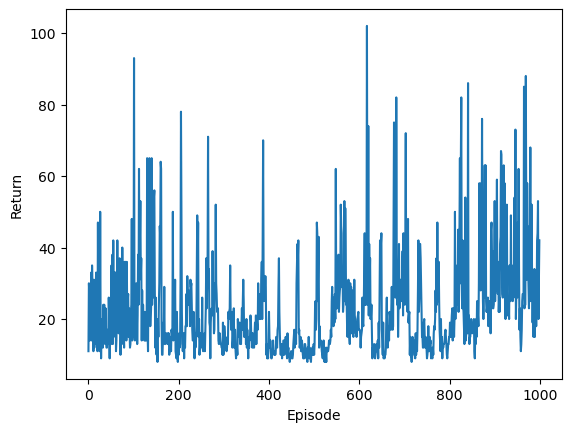

In [3]:
env = gym.make(ENVIRONMENT_ID)
env.action_space.seed(RNG_SEED)
model = LinearModel(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
returns = train_episodic_semi_grad_sarsa(
    env, model, loss_func, optimizer, device, RNG_SEED, NUM_EPISODES, EPS_START, EPS_END, EPS_DECAY, GRAD_CLIP_VALUE
)
env.close()
plot_returns(returns)

## Neural Network Model

Average return per episode: 74.521


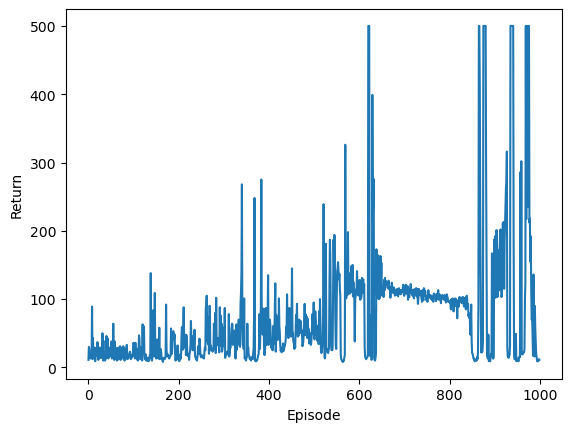

In [4]:
env = gym.make(ENVIRONMENT_ID)
env.action_space.seed(RNG_SEED)
model = SimpleNN(env.observation_space.shape[0], env.action_space.n, NN_HIDDEN_LAYER_SIZE).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
loss_func = nn.MSELoss()
returns = train_episodic_semi_grad_sarsa(
    env, model, loss_func, optimizer, device, RNG_SEED, NUM_EPISODES, EPS_START, EPS_END, EPS_DECAY, GRAD_CLIP_VALUE
)
env.close()
plot_returns(returns)

# Q-learning

## Linear model

Average return per episode: 22.073


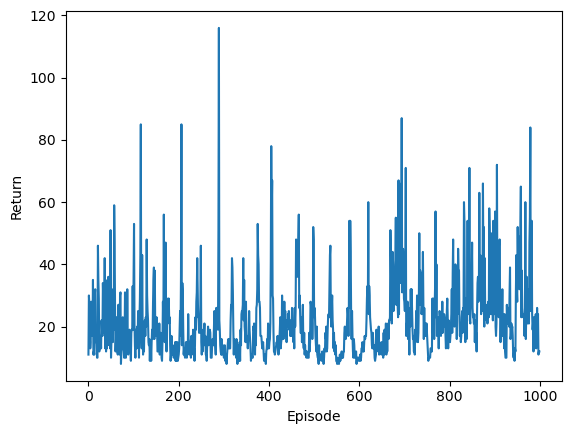

In [5]:
env = gym.make(ENVIRONMENT_ID)
env.action_space.seed(RNG_SEED)
model = LinearModel(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
returns = train_episodic_semi_grad_qlearning(
    env, model, loss_func, optimizer, device, RNG_SEED, NUM_EPISODES, EPS_START, EPS_END, EPS_DECAY, GRAD_CLIP_VALUE
)
env.close()
plot_returns(returns)

## Neural Network Model

Average return per episode: 56.693


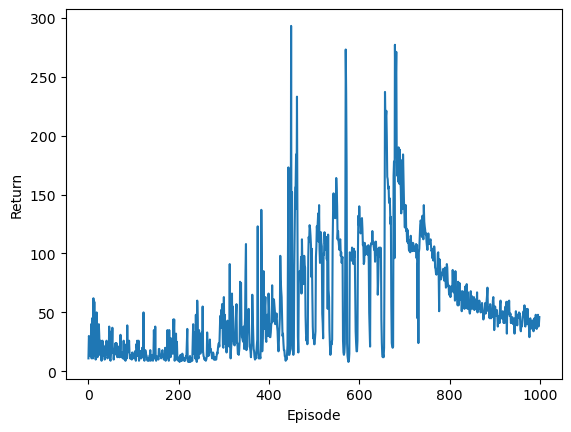

In [6]:
env = gym.make(ENVIRONMENT_ID)
env.action_space.seed(RNG_SEED)
model = SimpleNN(env.observation_space.shape[0], env.action_space.n, NN_HIDDEN_LAYER_SIZE).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
loss_func = nn.MSELoss()
returns = train_episodic_semi_grad_qlearning(
    env, model, loss_func, optimizer, device, RNG_SEED, NUM_EPISODES, EPS_START, EPS_END, EPS_DECAY, GRAD_CLIP_VALUE
)
env.close()
plot_returns(returns)

# Q-learning with experience replay

## Linear Model

Average return per episode: 25.07


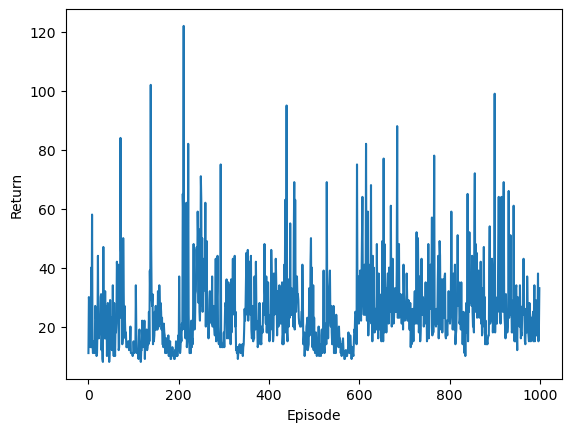

In [7]:
env = gym.make(ENVIRONMENT_ID)
env.action_space.seed(RNG_SEED)
model = LinearModel(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
returns = train_episodic_semi_grad_qlearning_exp_replay(
    env, model, loss_func, optimizer, device,
    RNG_SEED, NUM_EPISODES, EPS_START, EPS_END, EPS_DECAY, MEMORY_SIZE, BATCH_SIZE, GRAD_CLIP_VALUE
)
env.close()
plot_returns(returns)

## Neural Network Model

Average return per episode: 201.427


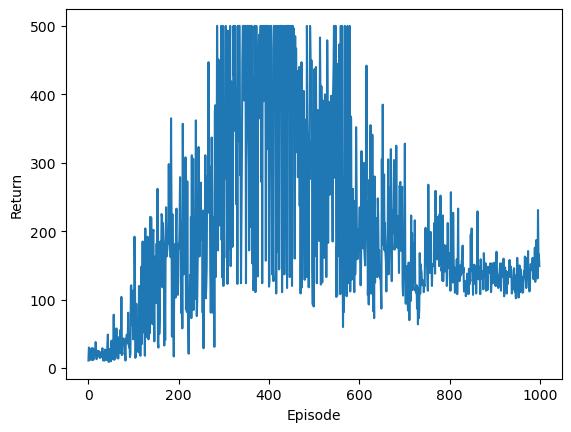

In [8]:
env = gym.make(ENVIRONMENT_ID)
env.action_space.seed(RNG_SEED)
model = SimpleNN(env.observation_space.shape[0], env.action_space.n, NN_HIDDEN_LAYER_SIZE).to(device)
#optimizer = optim.AdamW(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
loss_func = nn.MSELoss()
returns = train_episodic_semi_grad_qlearning_exp_replay(
    env, model, loss_func, optimizer, device,
    RNG_SEED, NUM_EPISODES, EPS_START, EPS_END, EPS_DECAY, MEMORY_SIZE, BATCH_SIZE, GRAD_CLIP_VALUE
)
env.close()
plot_returns(returns)

In [9]:
def train_episodic_semi_grad_qlearning_exp_replay(
        env, policy_model, target_model, loss_func, optimizer, device, rng_seed, num_episodes,
        eps_start, eps_end, eps_decay, memory_size, batch_size, grad_clip_value=None):
    eps = eps_start
    returns = []
    replay_memory = ReplayMemory(memory_size)
    for ep in range(num_episodes):
        # Set seed only one time per training run. For more info, see https://gymnasium.farama.org/api/env/.
        seed = rng_seed if ep == 0 else None
        observation, info = env.reset(seed=seed)
        state = torch.tensor(observation, device=device).unsqueeze(0)
        truncated = False
        terminated = False
        G = 0

        while not (terminated or truncated):
            action = select_action_eps_greedy(env, model, torch.tensor(observation, device=device), eps)
            observation, reward, terminated, truncated, info = env.step(action)
            G += reward
            next_state = torch.tensor(observation, device=device).unsqueeze(0)
            action = torch.tensor([[action]], device=device)
            reward = torch.tensor([reward], device=device)
            replay_memory.store(state, action, reward, None if terminated else next_state)
            experience_replay(policy_model, target_model, replay_memory, batch_size, loss_func, optimizer, grad_clip_value, device)
            # TODO: Update target_model at some point!!!!!!!!!!!!!!!
            state = next_state

        eps = update_eps(eps, eps_end, eps_decay)
        returns.append(G)
    return returns

Average return per episode: 257.331


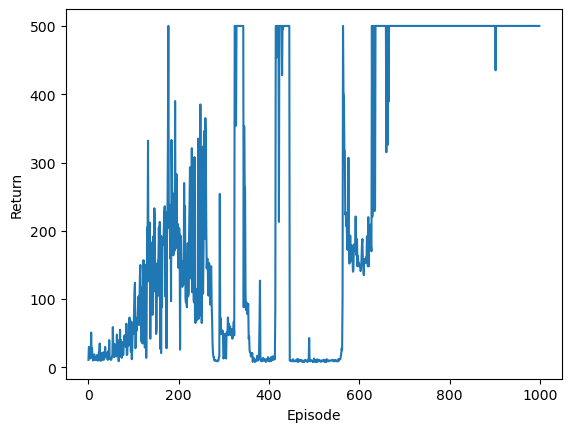

In [10]:
env = gym.make(ENVIRONMENT_ID)
env.action_space.seed(RNG_SEED)
model = SimpleNN(env.observation_space.shape[0], env.action_space.n, NN_HIDDEN_LAYER_SIZE).to(device)
#optimizer = optim.AdamW(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
loss_func = nn.MSELoss()
returns = train_episodic_semi_grad_qlearning_exp_replay(
    env, model, model, loss_func, optimizer, device,
    RNG_SEED, NUM_EPISODES, EPS_START, EPS_END, EPS_DECAY, MEMORY_SIZE, BATCH_SIZE, GRAD_CLIP_VALUE
)
env.close()
plot_returns(returns)